# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

The smartcab does not move at all. Because of this, it is collecting all the rewards where "no action" or "wait" were expected. The code that implements this behaviour is written below:

```python
# file environment.py lines 328 through 358

        # Agent wants to perform no action:
        elif action == None:
            if light == 'green' and inputs['oncoming'] != 'left': # No oncoming traffic
                violation = 1 # Minor violation


        # Did the agent attempt a valid move?
        if violation == 0:
            if action == agent.get_next_waypoint(): # Was it the correct action?
                reward += 2 - penalty # (2, 1)
            elif action == None and light != 'green': # Was the agent stuck at a red light?
                reward += 2 - penalty # (2, 1)
            else: # Valid but incorrect
                reward += 1 - penalty # (1, 0)

            # Move the agent
            if action is not None:
                location = ((location[0] + heading[0] - self.bounds[0]) % (self.bounds[2] - self.bounds[0] + 1) + self.bounds[0],
                            (location[1] + heading[1] - self.bounds[1]) % (self.bounds[3] - self.bounds[1] + 1) + self.bounds[1])  # wrap-around
                state['location'] = location
                state['heading'] = heading
        # Agent attempted invalid move
        else:
            if violation == 1: # Minor violation
                reward += -5
            elif violation == 2: # Major violation
                reward += -10
            elif violation == 3: # Minor accident
                reward += -20
            elif violation == 4: # Major accident
                reward += -40
```


Given that the agent is choosing action `None`, we have 3 different cases:
1. `None` + *red lights* = rewards
2. `None` + *green lights* + *oncoming traffic turning left* = rewards
3. `None` + *green lights* + *oncoming traffic not turning left* = penalties


### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*

#### *agent.py*

I chose three flags that affect the Simulator object. The comments below were extracted from the source code.

    update_delay - continuous time (in seconds) between actions, default is 2.0 seconds
    
I understand that `update_delay` defines the number of seconds between frame updates during the simulation. The default is 2 seconds. Increasing this number will cause the frames to be still for longer periods. Decreasing it will have the opposite effect.

    display      - set to False to disable the GUI if PyGame is enabled

I understand that `display` enables or disables the Graphical Simulation. The Graphical Simulation depends upon the PyGame being installed on the system. Even if this flag is set to `True`, if PyGame is not correctly installed, the Graphical Simulation will not run. If the flag is set to `False`, it will not run even if PyGame is enabled.
    
    log_metrics  - set to True to log trial and simulation results to /logs
    
I understand that `log_metrics` enables or disables metrics logging by the simulator. I extracted the following lines of code that explicit tell what is being logged.

```python
if self.log_metrics:
    self.log_writer.writerow({
        'trial': trial,
        'testing': self.env.trial_data['testing'],
        'parameters': self.env.trial_data['parameters'],
        'initial_deadline': self.env.trial_data['initial_deadline'],
        'final_deadline': self.env.trial_data['final_deadline'],
        'net_reward': self.env.trial_data['net_reward'],
        'actions': self.env.trial_data['actions'],
        'success': self.env.trial_data['success']
    })
```

- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*

When an agent performs an action, the function `def act(self, agent, action):` is called in `environment.py`.

- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*

From the source code, we have:
```python
    def render(self, trial, testing=False):
        """ This is the GUI render display of the simulation. 
            Supplementary trial data can be found from render_text. """

    def render_text(self, trial, testing=False):
        """ This is the non-GUI render display of the simulation. 
            Simulated trial data will be rendered in the terminal/command prompt. """
```

So `render_text()` renders display of the simulation in the command prompt, while `render()` renders display of the simulation on the PyGame window (GUI interface).


- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

In the file `planner.py`, the function `next_waypoint()` considers East-West direction before North-South.


-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


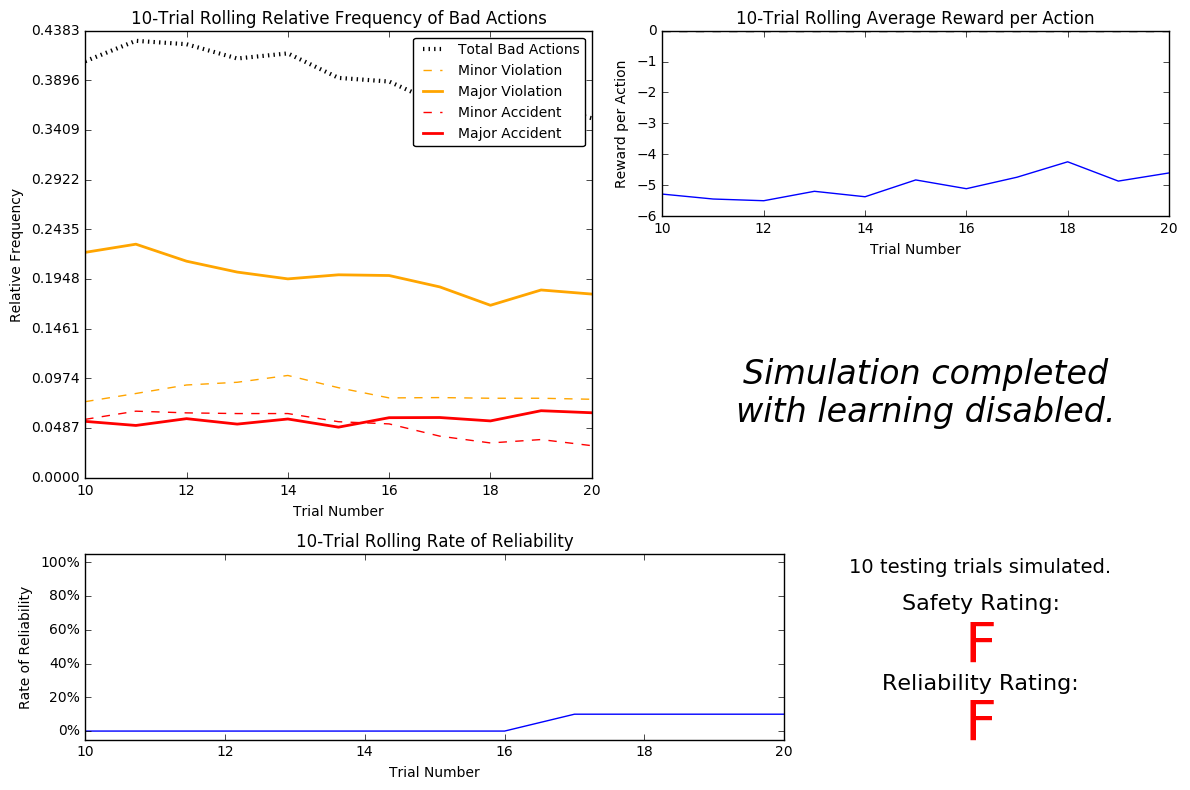

In [2]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

Given the visualization above and the fact that we implemented the agent to choose completely random actions, we can assert the following observations for each panel:

#### Panel 1 - Frequency of Bad Actions

Panel 1 shows the rolling relative frequency of bad actions collected throughout the 20 training trials. The first dashed line shows us that overall the agent is taking bad actions 42% of the time on average. Given that a bad action is selected, the following result is:
- An accident (minor or major) with 22% probability
- A violation (minor or major) with 78% probability

It is safe to say that the previous agent - that didn't move at all - caused less accidents and violations than this agent that moves randomly.

#### Panel 2 - Reward per Action

Panel 2 shows the rolling average reward per action collected throughout the 20 training trials. In average, the agent is rewarded -4.5 points per action. This means that the agent is being penalized more than being rewarded.

From panel 1, we can see that the agent doesn't always pick bad actions. It only picks bad actions around 35% of the times. So if the agent is picking good and neutral actions along with bad actions, this means that the bad actions it is choosing sometimes are really bad, because it is being heavily penalized and the rolling average reward per action is being dragged below 0.

#### Panel 3 - Rate of Reliability

Panel 3 shows the rolling rate of reliability. Reliability is the rate at which the agent arrives at the destination in some amount of time. With a random-moving agent, it is expected that it will rarely arrive at destination in time. Panel 3 confirms this by converging at 0% after 13 trials.

In fact, it doesn't make sense to measure the reliability of a random-moving agent, because if it ever reachs destination in time, it would be merely a coincidence and this result probably would not be reproducible if tried again.

#### Panel 4 Safety and Reliability Rating

Panel 4 shows the letter score (A through F) for the reliability and safety of our random moving agent. These scores were measured using the 10 testing trials, instead of the 20 training trials used as data for the other panels.

The panel shows a F score for both Reliability and Safety. This was expected, because a random moving agent in traffic is neither safe nor reliable.

#### Final Observations

- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*

The driving agent is making bad decisions 42% of the times on average. Given that a bad action is selected, the result is an accident (major or minor) with 22% probability.

- *Given that the agent is driving randomly, does the rate of reliabilty make sense?*

Given that the agent is driving randomly, the rate of reliability of 0% makes sense. Measuring the rate of reliability doesn't make sense. This is because reliability is related to the consistency that the agent reaches the destination on time, and a random-moving agent, by definition, is not consistent.

- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*

The rewards the agent is receiving suggest it's being heavily penalized. The graphs show that the agent only chooses bad actions 42% of the time, yet it is being rewarded -5 on average, meaning that, on average, the bad actions are pulling the reward below 0 more than the neutral and good actions are pulling it above.

- *As the number of trials increases, does the outcome of results change significantly?*

As the number of trials increase, the results converge to show that the agent isn't reliable and, on average, isn't safe. The only exception is the percentage of major violations which seems to increase as the number of trials increases.

- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

This smartcab would definetely be considered not safe nor reliable for its passengers. On a scale from A to F, it scored F on both reliability and safety. And based on intuition alone, it is safe to assume that anyone would consider a driver that takes random decisions on traffic unsafe and unreliable.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

**Answer:**

The feature that is most important for **safety** is the sensor data provided by `inputs`. At first, one could argue that all of the sensory data is important, but knowing that the agent should learn the US right-of-way, we can determine that:
- **lights** is important, because if the agent crosses a red light, it will cause a violation and maybe even an accident.
- **oncoming** is important, because even if the light is green, the agent cannot turn left without checking oncoming traffic, which could cause an accident otherwise.
- **left** is important, because the agent should yield on a right turn at a red light, if there is traffic coming from the left.
- **right** is irrelevant, because there are lights on all intersections. So **lights** overlaps and supersedes the information provided by **right** sensory data.

The feature that is most important for **efficiency** is `waypoint`. This feature represents where the smartcab should head to reach its destination.

The feature **deadline** is not relevant, but in another scenario it could be used to improve routing, so that the agent could choose longer routes that respect the deadline, while also avoid traffic for example.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

| Feature             |  Possible Values |
| ------------------- | ---------------- |
| waypoint            | forward, left, right |
| inputs['light']     | red, green |
| inputs['left']      | forward, left, right, none |
| inputs['oncoming']  | forward, left, right, none |
| **Size** | 96 |

Based on the combinations listed above, the state space size is 96. Running some simulations and analyzing the rewards on the Q-table output, I noticed that the agent seems to learn most of the rules of the US right-of-way with few trials.

Also, we could sacrifice some **safety** to improve the overall learning by removing the `inputs['left']`. This is the best candidate to be removed, because given the features we selected, there is only 4 combinations out of 96 that requires knowing `inputs["left"]` to avoid an accident, as shown by the table below:

| waypoint | light | left | oncoming | # of combinations | Result |
| -------- | ----- |------|----------|-------------------| ------ |
| right    | red   | forward | forward,left,right,None | 4 out 96 | Accident |

Dropping `inputs["left"]` would result in a state space of 24, which is considerably smaller than 96, making the agent much more effective in learning the US right-of-way rules. So the final state space is:

| Feature             |  Possible Values |
| ------------------- | ---------------- |
| waypoint            | forward, left, right |
| inputs['light']     | red, green |
| inputs['oncoming']  | forward, left, right, none |
| **Size** | 24 |

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

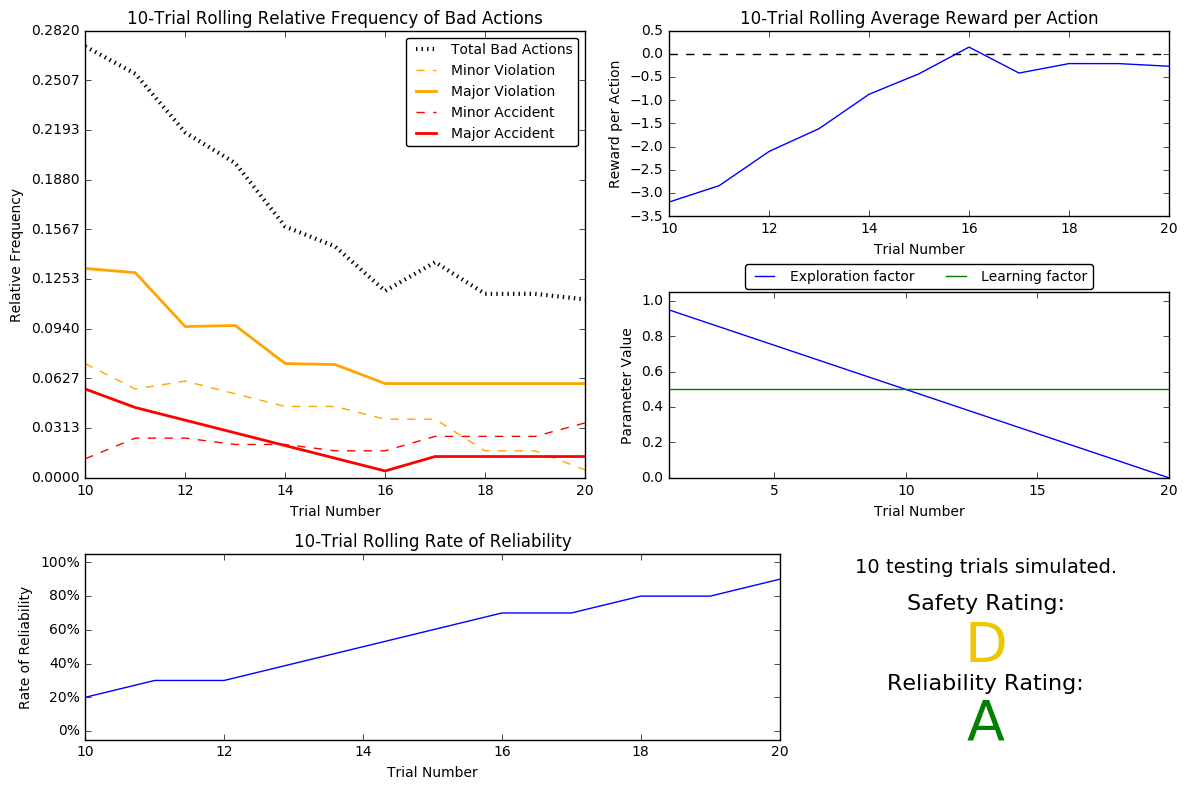

In [23]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*

There is only one similarity between the basic driving agent and the default Q-Learning Agent.

#### Both agents chose more bad actions on the first trials

From the first graph, we can see that, on the 10th trial mark, the rolling average which the agents chose bad actions is very high for both agents (28% and 40%). The difference is that, for the Q-Learning agent, the rolling average of bad decisions dropped to around 12% on the 20th trial, while for the basic agent it was still high, at around 35%.

-----

- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*

Based on the graphs, the informed driving agent learning, regarding security, converged at the 16th trial mark. On the reliability side though, the learning process steadily improved the reliability of the driving agent, with the rolling average reaching a peak of `90%` at the 20th trial mark.

This number makes sense given the epsilon-tolerance, because with this agent setup:

$\epsilon_{t+1} = \epsilon_{t} - 0.05$

$\epsilon_{0} = 1.0$

We know that the max number of training trials would always be `20`. Maybe if we increased the number of trials a little more, the reliability would be perfect at `100%`, but maybe not! We would have to experiment and see when it would converge.

-----

- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*


The decaying function implemented for $\epsilon$ is implicitly represented on the panel that shows the exploration and learning factor vs the number of trials. The decaying function is part of the line that represents the exploration factor, given by:

$y = 1.0 - \delta * x$

where $\delta$ is the decaying function (i.e. constant function equal to `0.05`).

-----

- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*

As the number of training trials increased, the total number of bad actions decreased and the average reward increased. These conclusions can be made by visualizing the Panels `10-trial Rolling Relative Frequency of Bad Actions` and `10-trial Rolling Average Reward per Action` respectively.

-----

- *How does the safety and reliability rating compare to the initial driving agent?*

The safety rating improved from F to D compared to the initial driving agent.

The reliability improved from F to A.

-----

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

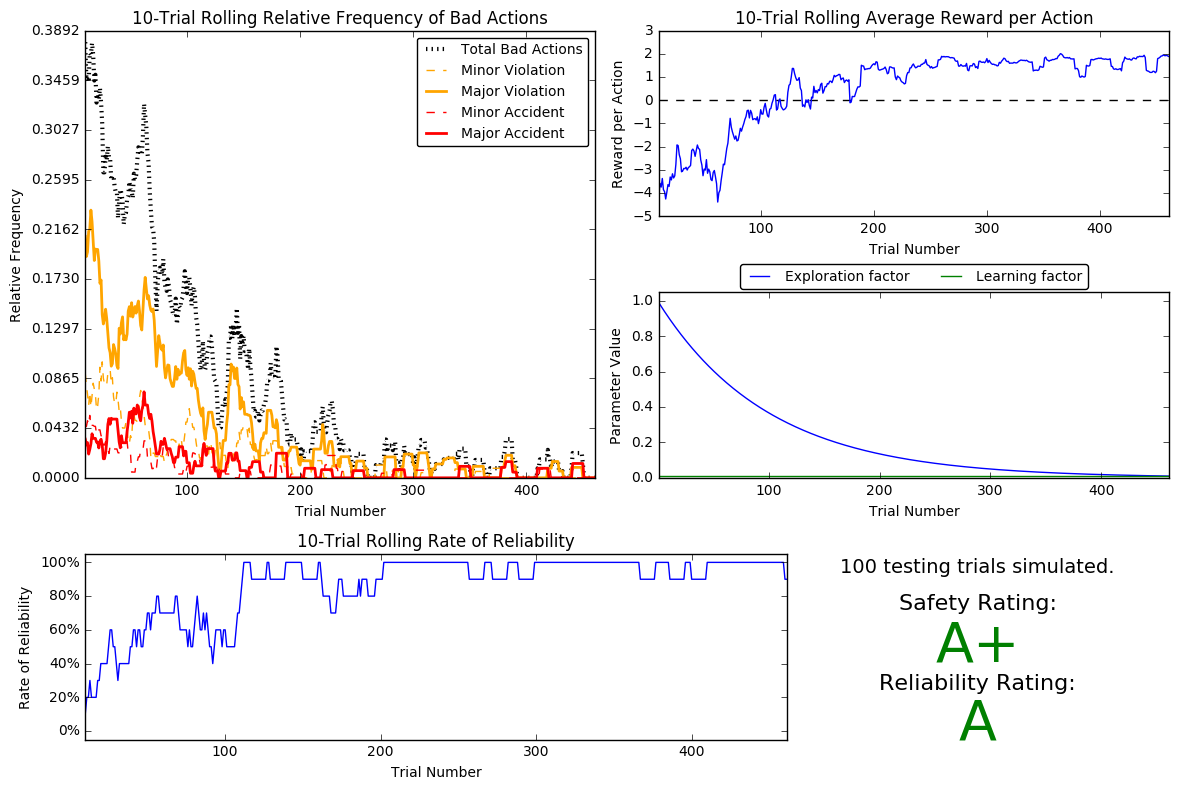

In [57]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

## Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

- *What decaying function was used for epsilon (the exploration factor)?*

The decaying function used for epsilon was the *Euler's number* exponential decaying function: $\epsilon = e^{-at}$.

I also tried:
- $\epsilon_{t+1} = \epsilon_{t} - 0.01$
- $\epsilon = a^t$
- $\epsilon = \frac{1}{t^2}$
- $\epsilon = \cos(at)$

I found that the *Euler's number* exponential decaying function provided better results more consistently.

- *Approximately how many training trials were needed for your agent before begining testing?*

I tried multiple combinations of alpha and epsilon-tolerance, which meant multiple training trials. Overall, I saw that the higher number of training trials, the more consistent were the results. With the selected decaying function, I had the following results:

| # trials | alpha | tolerance | safety | reliability |
| -------- | -------- | -------- | -------- | -------- |
| ~47 | 0.1 | 0.01 | A+ | B |
| ~33 | 0.1 | 0.04 | D | B |
| ~40 | 0.1 | 0.02 | D | B |
| ~95 | 0.05 | 0.01 | A+ | A |


At first, I thought that 33 training trials was the optimal number, because, analyzing the graphs, that is when all the rolling-rates converge at the best results. But then, after reducing the number of trials to 33 and 44, I saw the safety rating drop from `A+` to `D`. So I thought that, even though the rolling rates converged at 33, the agent still needed some more training trials to finish learning the safety rules.

- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*

I tried various combinations of epsilon-tolerance and alpha:

| # trials | alpha | tolerance | safety | reliability |
| -------- | -------- | -------- | -------- | -------- |
| 20  | 1.0  | 0.01 | F  | C |
| 20  | 0.9  | 0.01 | D  | A |
| 20  | 0.8  | 0.01 | D  | A |
| 20  | 0.7  | 0.01 | D  | F |
| 20  | 0.6  | 0.01 | D  | D |
| 20  | 0.5  | 0.01 | D  | A |
| 20  | 0.4  | 0.01 | D  | F |
| 20  | 0.3  | 0.01 | F  | D |
| 24  | 0.2  | 0.01 | D  | B |
| 47  | 0.1  | 0.01 | D  | B |
| 93  | 0.05 | 0.01 | A+ | D |
| 461 | 0.01 | 0.01 | A+ | A |

From these empirical results, I found that the best combination of alpha and epsilon-tolerance was `0.01` and `0.01`, respectively. Although other values seem to achieve good results in reliability, I found that these were not consistent. Changing the random seed would affect the training of the agent, and also the reliability rating. The selected parameter values were consistent throughout the trials, even when changing the random seed.

Also, analyizing the table above, we can see some nice behaviour:
- The agent is more safe when it trains for longer periods, with low-value alphas.
- The reliability is severely impacted by the random seed, and while the table above show good results for 0.9, 0.8, 0.5 and others, these results weren't repeated when I changed the random seed.
- Overall, the agent improves with more training trials, as expected.

- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*

This Q-Learner improved on the safety rating, when compared to the Q-Learner from the previous section. It went from D to A+ in safety, because it had more training trials to improve its Q-table, and learn both safety and reliability rewards.

- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*

Analyzing the Q-table output, it is clear that the driving agent learned both, how to follow waypoints on green lights and how to avoid traffic accidents by respecting the US right-of-way. The only exception is the right-turn on a red light, which we intentionally left out to improve the Q-Learning process.


- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

I'm satisfied with the ratings of the Smartcab (A+ and A), because:
- the ratings are very good (90% for reliability and 100% for safety)
- the Q-table output is very close to what I expected would be the optimal policy for this simulation
- this agent got very consistent results on multiple simulations. It ran A+ and A on a setting where I ran 1000 testing trials

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterwards, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

**Answer:** 

The optimal policy with the inputs I selected would be:

<center>**Optimal Policy**</center>

| waypoint | lights | oncoming | action |
| -------- | ------ | -------- | ------ |
| any      | red    | any      | **None**   |
| left     | green  | None or left | **left** |
| left     | green  | forward or right | **None** |
| right    | green  | any      | **right**  |
| forward  | green  | any      | **forward**|

The Q-Learner policy matches the optimal policy listed above for most states, except for the states `(left, green, right or forward)`. On this state, the policy suggests an action different from *None*. See the Q-Table entry below:
```
('left', 'green', 'forward')
 -- forward : 0.05
 -- right : 0.55
 -- None : -0.25
 -- left : -2.10
Highest reward: right
 
('left', 'green', 'right')
 -- forward : 0.04
 -- right : 0.31
 -- None : -0.49
 -- left : -0.59
Highest reward: right
```

What is interesting to note is that, even though `None` is the optimal action, the learner failed to learn this, because of the reward system in place. The code listed below shows how the agent is being rewarded:

```python
        # environment.py

        # Agent wants to drive left:
307        elif action == 'left':
308            if light != 'green': # Running a red light
309               violation = 2 # Major violation
310                if inputs['left'] == 'forward' or inputs['right'] == 'forward': # Cross traffic
311                    violation = 4 # Accident
312                elif inputs['oncoming'] == 'right': # Oncoming car turning right
313                    violation = 4 # Accident
314            else: # Green light
315                if inputs['oncoming'] == 'right' or inputs['oncoming'] == 'forward': # Incoming traffic
316                    violation = 3 # Accident
317                else: # Valid move!
318                    heading = (heading[1], -heading[0])
        
        # More code here (...)

334        # Did the agent attempt a valid move?
335        if violation == 0:
336            if action == agent.get_next_waypoint(): # Was it the correct action?
337               reward += 2 - penalty # (2, 1)
338            elif action == None and light != 'green': # Was the agent stuck at a red light?
339                reward += 2 - penalty # (2, 1)
340            else: # Valid but incorrect
341                reward += 1 - penalty # (1, 0)
```

For the selected state `(left, green, any)`, line 315 shows the 2 cases when an accident would happen:
```python
315                if inputs['oncoming'] == 'right' or inputs['oncoming'] == 'forward': # Incoming traffic
```

This explains why `left` is negative on the Q-table: **it would cause an accident and the agent is heavily penalized (-20 reward)**.

In contrast, `right` or `forward` fall into the same category of rewards. **They will not follow the waypoint and will not cause an accident, but they are valid moves.** Line 341 shows the reward the agent gets on these cases:
```python
340            else: # Valid but incorrect
341                reward += 1 - penalty # (1, 0)
```

And what is most interesting is that, what I expected to be the optimal action (`None`), **is penalized by the reward system as a minor violation**:

```python
328     # Agent wants to perform no action:
329     elif action == None:
330         if light == 'green' and inputs['oncoming'] != 'left': # No oncoming traffic
331             violation = 1 # Minor violation
```

That explains why `right` and `forward` have positive reward values, while `None` has a negative value.

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

Future rewards won't work for this project, because of two characteristics.

- [Agent] The agent sensors can't predict future states correctly. 

For example, to correctly predict which path would result in the better reward, the agent would have to know that it has to turn left *then* turn right *then* go forward. With its current sensors, it doesn't have access to where the destination is, but only the next waypoint.

- [Environment] The environment is ever changing, with lights changing and other agents moving around.

For example, even if the agent knew where the destination was, it is not capable of knowing when a light will turn green or red, and where the other cars will be when it takes an action.

Also, because destinations are randomly chosen through the grid, there won't be an optimal policy, using future rewards, that covers all of them, because for each destination, there will be different paths that yield the best rewards.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.